In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

## Load Benchmark Data

In [2]:
def load_benchmark_data(json_path):
    """Load and parse benchmark JSON file."""
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    benchmarks = data['benchmarks']
    df = pd.DataFrame(benchmarks)
    
    # Parse benchmark names to extract components
    df[['Implementation', 'Pattern', 'Size1', 'Size2', 'Extra']] = df['name'].str.extract(
        r'([^/]+)/([^/]+)/([^/]+)/([^/]+)/(.+)'
    )
    
    # Convert size to integer
    df['Size'] = df['Size'].astype(int)
    
    # Add computation time (cpu_time - communication for MPI implementations)
    df['comp_time'] = df['cpu_time']
    df['comm_time'] = df.get('Comm_ms', 0)
    
    # For MPI implementations, separate computation from communication
    mask = df['comm_time'] > 0
    df.loc[mask, 'comp_time'] = df.loc[mask, 'cpu_time'] - df.loc[mask, 'comm_time']
    
    return df, data['context']

# Load the most recent benchmark
benchmark_file = '../benchmark_results/benchmark_20251213_064344.json'
df, context = load_benchmark_data(benchmark_file)

print(f"Loaded {len(df)} benchmarks")
print(f"\nHost: {context['host_name']}")
print(f"Date: {context['date']}")
print(f"CPUs: {context['num_cpus']}")
print(f"\nImplementations found: {sorted(df['Implementation'].unique())}")

Loaded 20 benchmarks

Host: snp-instance-primary
Date: 2025-12-13T06:43:49+00:00
CPUs: 1

Implementations found: ['CpuSnp', 'CudaMpiSnp', 'CudaSnp', 'NaiveCudaMpiSnp', 'SparseCudaSnp']


## Data Preview

In [3]:
# Show sample of the data
display_cols = ['Implementation', 'Pattern', 'Size', 'real_time', 'cpu_time', 'comm_time', 'comp_time']
df[display_cols].head(10)

,Implementation,Pattern,Size,real_time,cpu_time,comm_time,comp_time
0,CpuSnp,Random,100,3.918012,2.305715,NaN,2.305715
1,CpuSnp,Sorted,100,4.782027,2.244293,NaN,2.244293
2,CpuSnp,Random,1000,6747.443318,3189.509515,NaN,3189.509515
3,CpuSnp,NearlySorted,1000,9488.640027,3282.453240,NaN,3282.453240
4,CudaSnp,Random,100,22.370834,5.222695,NaN,5.222695
5,CudaSnp,Sorted,100,15.209720,5.081815,NaN,5.081815
6,CudaSnp,Random,1000,464.685510,228.930346,NaN,228.930346
7,CudaSnp,NearlySorted,1000,407.187063,169.939594,NaN,169.939594
8,SparseCudaSnp,Random,100,8.461746,4.578946,NaN,4.578946
9,SparseCudaSnp,Sorted,100,8.187824,4.581435,NaN,4.581435


## Configuration: Available Implementations

**Add new implementations here** - just add the name to the dictionary with a display color.

In [4]:
# Configuration: Add new implementations here
IMPLEMENTATIONS = {
    'CpuSnp': {'color': '#1f77b4', 'has_mpi': False, 'label': 'CPU'},
    'CudaSnp': {'color': '#ff7f0e', 'has_mpi': False, 'label': 'CUDA'},
    'SparseCudaSnp': {'color': '#2ca02c', 'has_mpi': False, 'label': 'Sparse CUDA'},
    'NaiveCudaMpiSnp': {'color': '#d62728', 'has_mpi': True, 'label': 'Naive CUDA+MPI'},
    'CudaMpiSnp': {'color': '#9467bd', 'has_mpi': True, 'label': 'CUDA+MPI'},
}

# Filter to only implementations present in data
available_implementations = [impl for impl in IMPLEMENTATIONS.keys() 
                            if impl in df['Implementation'].values]

print(f"Available implementations: {available_implementations}")

Available implementations: ['CpuSnp', 'CudaSnp', 'SparseCudaSnp', 'NaiveCudaMpiSnp', 'CudaMpiSnp']


## Interactive Visualization: Select Implementations

In [5]:
def create_comparison_plot(selected_implementations, metric='real_time', show_comm_breakdown=True):
    """
    Create comparison plots for selected implementations.
    
    Args:
        selected_implementations: List of implementation names to plot
        metric: Which time metric to use ('real_time', 'cpu_time', 'comp_time')
        show_comm_breakdown: Whether to show communication breakdown for MPI implementations
    """
    if not selected_implementations:
        print("Please select at least one implementation")
        return
    
    # Filter data
    plot_df = df[df['Implementation'].isin(selected_implementations)].copy()
    
    # Create subplots for different data patterns
    patterns = sorted(plot_df['Pattern'].unique())
    fig, axes = plt.subplots(1, len(patterns), figsize=(6*len(patterns), 6))
    if len(patterns) == 1:
        axes = [axes]
    
    for idx, pattern in enumerate(patterns):
        ax = axes[idx]
        pattern_df = plot_df[plot_df['Pattern'] == pattern]
        
        # Group by implementation and size
        x_pos = np.arange(len(pattern_df['Size'].unique()))
        width = 0.8 / len(selected_implementations)
        
        for i, impl in enumerate(selected_implementations):
            impl_df = pattern_df[pattern_df['Implementation'] == impl].sort_values('Size')
            
            if len(impl_df) == 0:
                continue
            
            config = IMPLEMENTATIONS[impl]
            
            if config['has_mpi'] and show_comm_breakdown:
                # Stack computation and communication time
                comp = impl_df['comp_time'].values
                comm = impl_df['comm_time'].values
                
                ax.bar(x_pos + i*width, comm, width,
                      label=f"{config['label']} (Comm)",
                      color=config['color'], alpha=0.4, hatch='//')
                ax.bar(x_pos + i*width, comp, width, bottom=comm, 
                      label=f"{config['label']} (Comp)",
                      color=config['color'], alpha=0.8)
            else:
                # Just show the total time
                times = impl_df[metric].values
                ax.bar(x_pos + i*width, times, width,
                      label=config['label'],
                      color=config['color'], alpha=0.8)
        
        ax.set_xlabel('Problem Size', fontsize=12, fontweight='bold')
        ax.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
        ax.set_title(f'{pattern} Data', fontsize=14, fontweight='bold')
        ax.set_xticks(x_pos + width * (len(selected_implementations) - 1) / 2)
        ax.set_xticklabels(sorted(pattern_df['Size'].unique()))
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_speedup_plot(selected_implementations, baseline='CpuSnp'):
    """
    Create speedup comparison relative to baseline implementation.
    """
    if baseline not in selected_implementations:
        print(f"Baseline '{baseline}' not in selected implementations")
        return
    
    if len(selected_implementations) < 2:
        print("Select at least 2 implementations for speedup comparison")
        return
    
    plot_df = df[df['Implementation'].isin(selected_implementations)].copy()
    patterns = sorted(plot_df['Pattern'].unique())
    
    fig, axes = plt.subplots(1, len(patterns), figsize=(6*len(patterns), 6))
    if len(patterns) == 1:
        axes = [axes]
    
    for idx, pattern in enumerate(patterns):
        ax = axes[idx]
        pattern_df = plot_df[plot_df['Pattern'] == pattern]
        
        # Get baseline times
        baseline_df = pattern_df[pattern_df['Implementation'] == baseline][['Size', 'real_time']]
        baseline_df = baseline_df.rename(columns={'real_time': 'baseline_time'})
        
        # Calculate speedup for each implementation
        for impl in selected_implementations:
            if impl == baseline:
                continue
            
            impl_df = pattern_df[pattern_df['Implementation'] == impl][['Size', 'real_time']]
            merged = impl_df.merge(baseline_df, on='Size')
            merged['speedup'] = merged['baseline_time'] / merged['real_time']
            
            config = IMPLEMENTATIONS[impl]
            ax.plot(merged['Size'], merged['speedup'], 
                   marker='o', linewidth=2, markersize=8,
                   label=config['label'], color=config['color'])
        
        ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Baseline')
        ax.set_xlabel('Problem Size', fontsize=12, fontweight='bold')
        ax.set_ylabel(f'Speedup vs {IMPLEMENTATIONS[baseline]["label"]}', fontsize=12, fontweight='bold')
        ax.set_title(f'{pattern} Data', fontsize=14, fontweight='bold')
        ax.set_xscale('log')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_communication_overhead_plot(selected_implementations):
    """
    Show communication overhead percentage for MPI implementations.
    """
    mpi_impls = [impl for impl in selected_implementations 
                 if IMPLEMENTATIONS[impl]['has_mpi']]
    
    if not mpi_impls:
        print("No MPI implementations selected")
        return
    
    plot_df = df[df['Implementation'].isin(mpi_impls)].copy()
    plot_df['comm_percentage'] = (plot_df['comm_time'] / plot_df['cpu_time']) * 100
    
    patterns = sorted(plot_df['Pattern'].unique())
    fig, axes = plt.subplots(1, len(patterns), figsize=(6*len(patterns), 6))
    if len(patterns) == 1:
        axes = [axes]
    
    for idx, pattern in enumerate(patterns):
        ax = axes[idx]
        pattern_df = plot_df[plot_df['Pattern'] == pattern]
        
        for impl in mpi_impls:
            impl_df = pattern_df[pattern_df['Implementation'] == impl].sort_values('Size')
            config = IMPLEMENTATIONS[impl]
            
            ax.plot(impl_df['Size'], impl_df['comm_percentage'],
                   marker='o', linewidth=2, markersize=8,
                   label=config['label'], color=config['color'])
        
        ax.set_xlabel('Problem Size', fontsize=12, fontweight='bold')
        ax.set_ylabel('Communication Overhead (%)', fontsize=12, fontweight='bold')
        ax.set_title(f'{pattern} Data', fontsize=14, fontweight='bold')
        ax.set_xscale('log')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Interactive Widget Controls

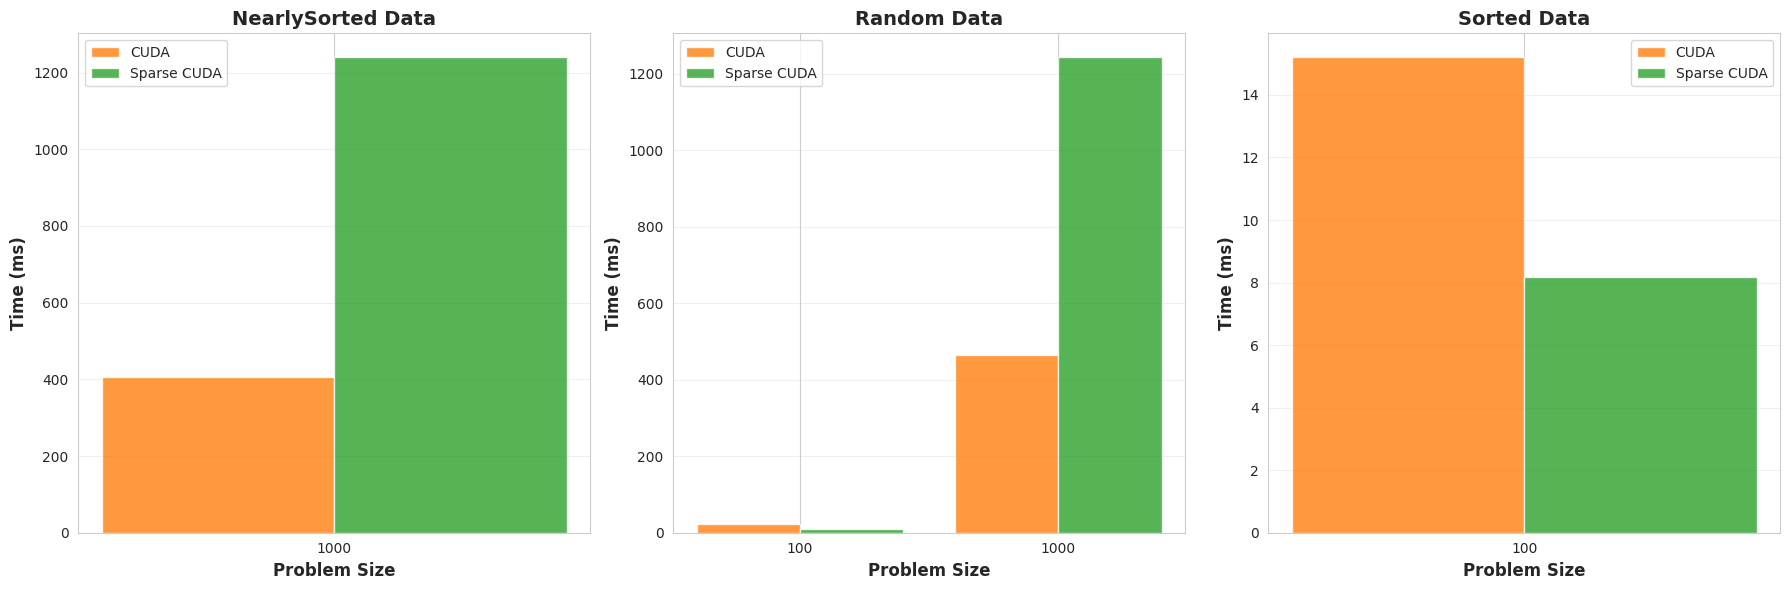

In [ ]:
# Create interactive widgets
implementation_selector = widgets.SelectMultiple(
    options=available_implementations,
    value=available_implementations[:2] if len(available_implementations) >= 2 else available_implementations,
    description='Implementations:',
    disabled=False,
    style={'description_width': 'initial'}
)

plot_type = widgets.Dropdown(
    options=['Time Comparison', 'Speedup Analysis', 'Communication Overhead'],
    value='Time Comparison',
    description='Plot Type:',
    disabled=False,
)

metric_selector = widgets.Dropdown(
    options=['real_time', 'cpu_time', 'comp_time'],
    value='real_time',
    description='Metric:',
    disabled=False,
)

show_comm_checkbox = widgets.Checkbox(
    value=True,
    description='Show MPI Comm Breakdown',
    disabled=False,
)

baseline_selector = widgets.Dropdown(
    options=available_implementations,
    value=available_implementations[0],
    description='Baseline:',
    disabled=False,
)

def on_plot_button_click(b):
    selected = list(implementation_selector.value)
    
    if plot_type.value == 'Time Comparison':
        create_comparison_plot(selected, metric_selector.value, show_comm_checkbox.value)
    elif plot_type.value == 'Speedup Analysis':
        create_speedup_plot(selected, baseline_selector.value)
    elif plot_type.value == 'Communication Overhead':
        create_communication_overhead_plot(selected)

plot_button = widgets.Button(
    description='Generate Plot',
    button_style='primary',
    icon='chart-bar'
)
plot_button.on_click(on_plot_button_click)

# Layout
ui = widgets.VBox([
    widgets.HTML("<h3>Select Implementations and Plot Options</h3>"),
    implementation_selector,
    plot_type,
    widgets.HBox([metric_selector, show_comm_checkbox]),
    baseline_selector,
    plot_button
])

display(ui)

## Quick Analysis: All Implementations

TIME COMPARISON


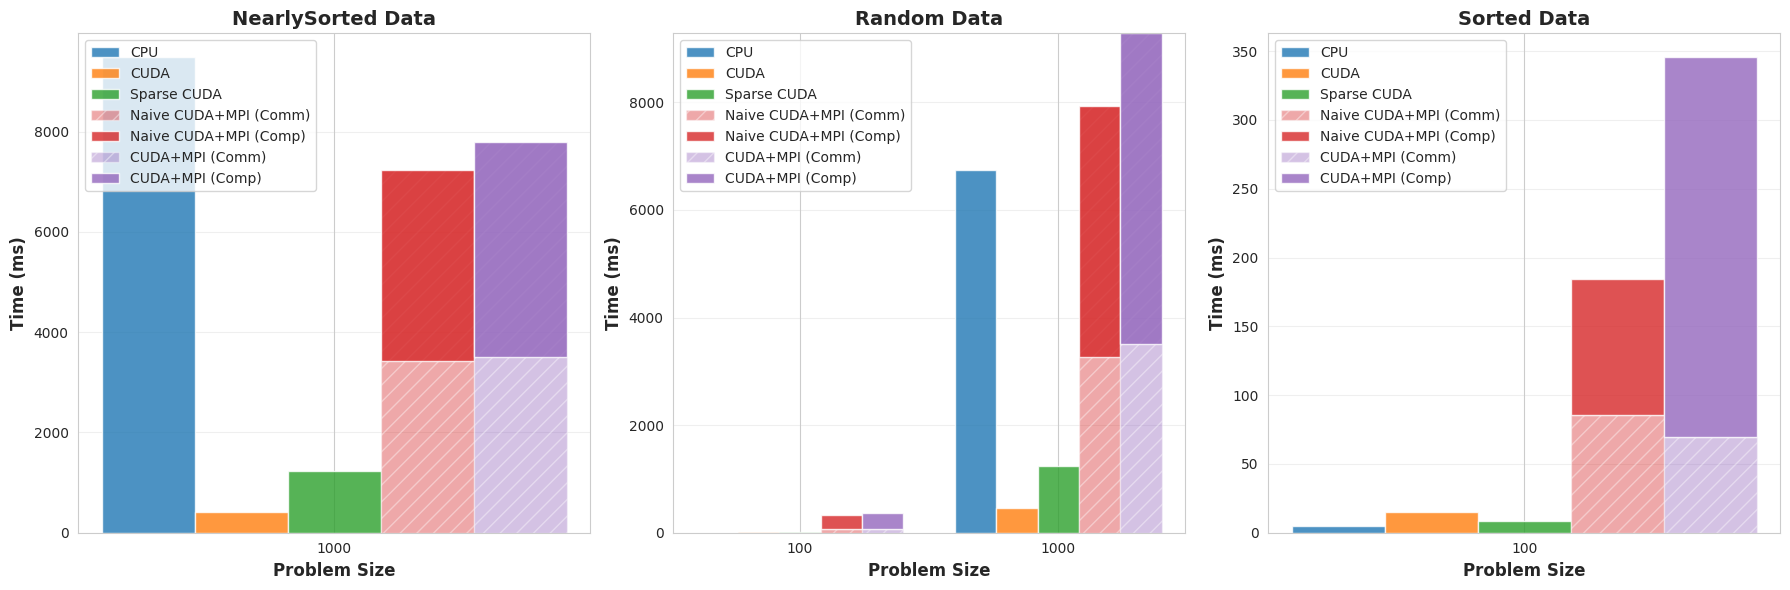

In [7]:
# Generate all plots automatically
print("=" * 80)
print("TIME COMPARISON")
print("=" * 80)
create_comparison_plot(available_implementations, 'real_time', show_comm_breakdown=True)

SPEEDUP ANALYSIS


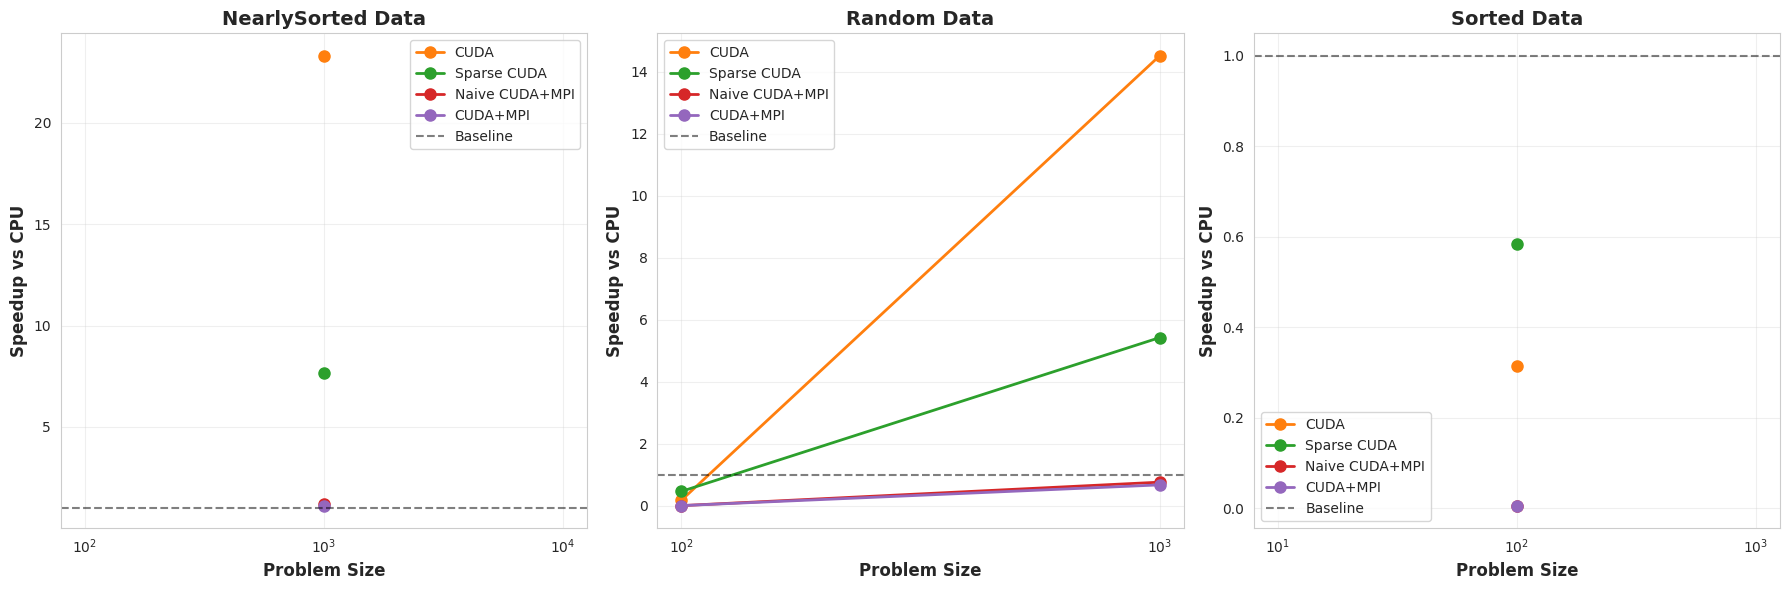

In [8]:
# Speedup analysis
if len(available_implementations) >= 2:
    print("=" * 80)
    print("SPEEDUP ANALYSIS")
    print("=" * 80)
    create_speedup_plot(available_implementations, baseline='CpuSnp')

COMMUNICATION OVERHEAD


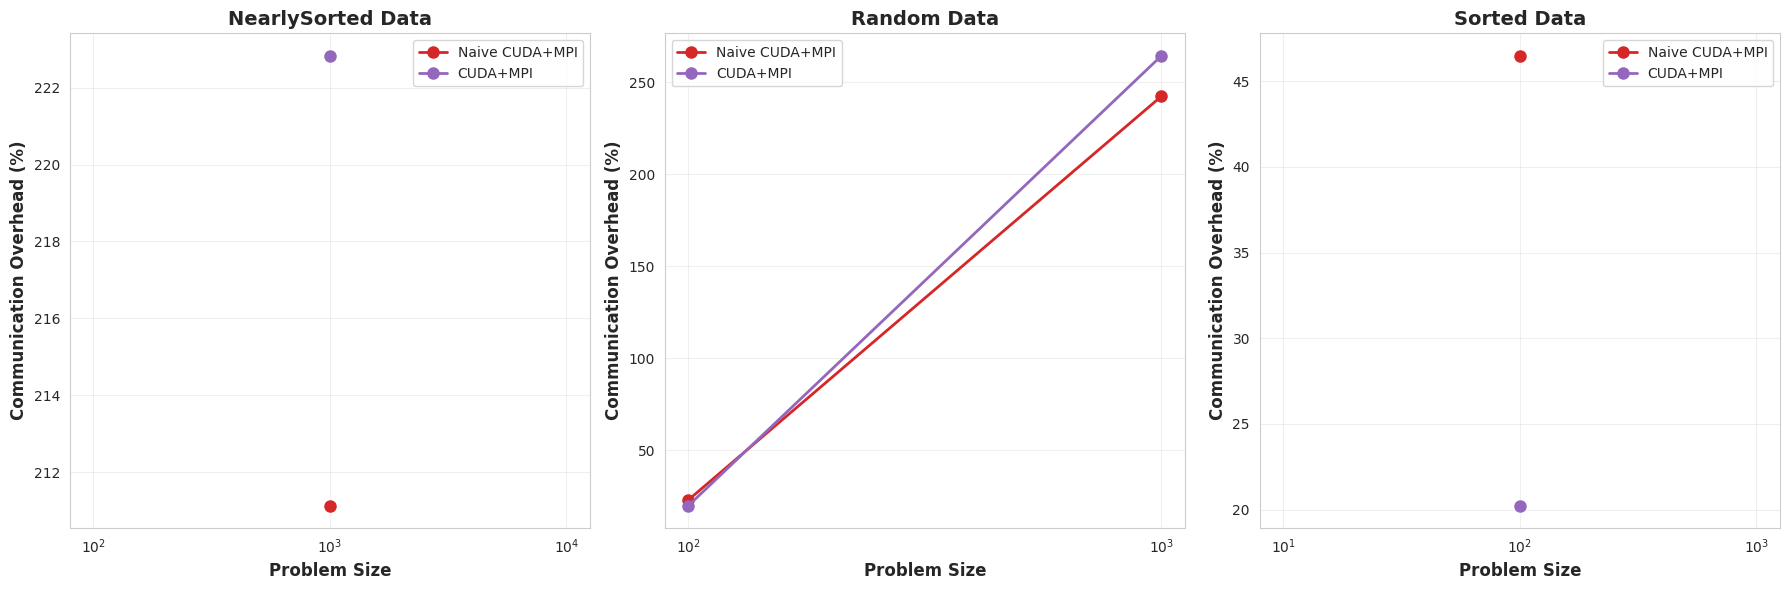

In [9]:
# Communication overhead
mpi_implementations = [impl for impl in available_implementations 
                       if IMPLEMENTATIONS[impl]['has_mpi']]
if mpi_implementations:
    print("=" * 80)
    print("COMMUNICATION OVERHEAD")
    print("=" * 80)
    create_communication_overhead_plot(mpi_implementations)

## Summary Statistics

In [10]:
# Create summary table
summary_data = []

for impl in available_implementations:
    impl_df = df[df['Implementation'] == impl]
    config = IMPLEMENTATIONS[impl]
    
    summary_data.append({
        'Implementation': config['label'],
        'Avg Real Time (ms)': impl_df['real_time'].mean(),
        'Avg CPU Time (ms)': impl_df['cpu_time'].mean(),
        'Avg Comm Time (ms)': impl_df['comm_time'].mean() if config['has_mpi'] else 0,
        'Comm Overhead (%)': (impl_df['comm_time'].mean() / impl_df['cpu_time'].mean() * 100) if config['has_mpi'] else 0,
        'Test Count': len(impl_df)
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(2)
print("\nSummary Statistics Across All Tests:")
display(summary_df)


Summary Statistics Across All Tests:


,Implementation,Avg Real Time (ms),Avg CPU Time (ms),Avg Comm Time (ms),Comm Overhead (%),Test Count
0,CPU,4061.20,1619.13,0.00,0.00,4
1,CUDA,227.36,102.29,0.00,0.00,4
2,Sparse CUDA,625.03,305.71,0.00,0.00,4
3,Naive CUDA+MPI,4609.18,1804.91,3832.19,212.32,4
4,CUDA+MPI,5005.43,1928.37,4303.93,223.19,4


## Load Different Benchmark File (Optional)

In [11]:
# Uncomment and modify to load a different benchmark file
# benchmark_file = 'benchmark_results/benchmark_YYYYMMDD_HHMMSS.json'
# df, context = load_benchmark_data(benchmark_file)
# print(f"Loaded {len(df)} benchmarks from {benchmark_file}")